<a href="https://colab.research.google.com/github/yuzhipeng588/llm/blob/main/ImageSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from huggingface_hub import login
login()

In [4]:
import os
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HF_TOKEN"))

In [9]:
import os
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader

from typing import List, Union, Tuple

from transformers import CLIPProcessor, CLIPModel

!pip install faiss-cpu
import faiss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 19.5 MB/s eta 0:00:00


In [5]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [10]:
device = "cpu" #setting the device

from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Woleek/imagemeow")

README.md:   0%|          | 0.00/889 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2184 [00:00<?, ? examples/s]

In [12]:
def encode_images(dataset, batch_size: int):
    def transform_fn(el):
        # Decode the image if it's a binary string
        if isinstance(el['image'], bytes):
            imgs = Image().decode_example(el['image'])
        else:
            imgs = el['image']
        # 'processor' is a utility (likely from Hugging Face Transformers) that
        # resizes, normalizes, and converts the image into a PyTorch tensor.
        # 'return_tensors='pt'' specifies the output should be a PyTorch tensor.
        return processor(images=imgs, return_tensors='pt')
    # This is a highly efficient step. It tells the dataset to apply our
    # transform_fn to each item on-the-fly, right before it's needed.
    dataset.set_transform(transform_fn)
    # The DataLoader takes our transformed dataset and automatically groups
    # the items into batches of the specified 'batch_size'.
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    # Sets up a tqdm progress bar to visualize our progress.
    pbar = tqdm(total=len(dataset) // batch_size, position=0)
    # This is a critical optimization. It tells PyTorch not to calculate
    # gradients, which saves a lot of memory and computation since we are
    # only doing inference (getting features), not training the model.
    with torch.no_grad():
        for batch in dataloader:
            # Move the batch of data to the active computing device (e.g., GPU).
            batch = {k:v.to(device) for k,v in batch.items()}
            # This is the core step! It passes the processed batch to the model
            # to get the image features (embeddings).
            # The features are moved back to the CPU and converted to a NumPy array.
            # .detach() removes it from the computation graph.
            # .cpu() moves it from the GPU to the CPU.
            # .numpy() converts the tensor to a NumPy array.
            image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
            # Update the progress bar.
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

# Assuming 'ds' is the dataset loaded from Hugging Face
vector_embedding = np.array(encode_images(ds['validation'], 32))/ np.linalg.norm(vector_embedding, ord=2, axis=-1, keepdims=True) # Using the training split of the dataset

69it [19:28, 16.94s/it]


In [37]:
save_directory = './image_search'
os.makedirs(save_directory, exist_ok=True)

with open(save_directory + '/image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

api.upload_folder(
    folder_path=save_directory,
    repo_id="thaitea2021/experimental",
    repo_type="model",
    path_in_repo="image_search/"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...arch/image_embeddings.pkl:  98%|#########8| 4.40MB / 4.47MB            

CommitInfo(commit_url='https://huggingface.co/thaitea2021/experimental/commit/e8a7c9e4fdcb646671e09e6bb79d45e3a9ccb74f', commit_message='Upload folder using huggingface_hub', commit_description='', oid='e8a7c9e4fdcb646671e09e6bb79d45e3a9ccb74f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/thaitea2021/experimental', endpoint='https://huggingface.co', repo_type='model', repo_id='thaitea2021/experimental'), pr_revision=None, pr_num=None)

In [38]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

In [41]:
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: processor(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)


search_text = "cat is drink water"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
# L2 Norm, normalize it to have unit vectors
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00,  7.48it/s]


In [42]:
# reshape since the text_search_embedding is a single vector
distances, indices = index.search(text_search_embedding.reshape(1, -1), 2) #2 represent top n results required
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
# Sort based on the distances (inner product), in descending order for most similar
indices_distances.sort(key=lambda x: x[1], reverse=True)

In [31]:
# Inspect the dataset features to find the correct column name for images
print(ds['validation'].features)
print(ds['validation'][2])

{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['Abyssinian', 'Angora', 'Burmese cat', 'Egyptian cat', 'Maltese', 'Manx', 'Persian cat', 'Siamese cat', 'blue point Siamese', 'cat', 'domestic cat', 'kitty', 'native cat', 'tabby', 'tiger cat', 'tom', 'tortoiseshell'])}
{'pixel_values': tensor([[[-0.5514, -0.5076, -0.5076,  ..., -0.6390, -0.6536, -0.6682],
         [-0.5514, -0.5222, -0.5076,  ..., -0.6390, -0.6682, -0.6682],
         [-0.5368, -0.5222, -0.5222,  ..., -0.6536, -0.6682, -0.6828],
         ...,
         [-0.7850, -0.7558, -0.7412,  ..., -1.6901, -1.5295, -1.4419],
         [-0.7558, -0.7412, -0.7266,  ..., -1.5587, -1.3835, -1.2521],
         [-0.7704, -0.7850, -0.7704,  ..., -1.5733, -1.4419, -1.2813]],

        [[-0.4014, -0.4164, -0.4164,  ..., -0.5815, -0.5965, -0.6115],
         [-0.4164, -0.3864, -0.3864,  ..., -0.5815, -0.6115, -0.6115],
         [-0.4014, -0.3864, -0.3864,  ..., -0.5965, -0.6115, -0.6265],
         ...,
         [-0.5965, -0.6265

In [32]:
# Inspect the pixel values of a sample image
if len(ds['validation']) > 0 and 'pixel_values' in ds['validation'][0]:
    sample_pixel_values = ds['validation'][0]['pixel_values']
    print(f"Data type of pixel_values: {sample_pixel_values.dtype}")
    print(f"Shape of pixel_values: {sample_pixel_values.shape}")
    print(f"Min value of pixel_values: {torch.min(sample_pixel_values)}")
    print(f"Max value of pixel_values: {torch.max(sample_pixel_values)}")
else:
    print("Could not access pixel_values from the dataset.")

Data type of pixel_values: torch.float32
Shape of pixel_values: torch.Size([3, 224, 224])
Min value of pixel_values: -1.7220815420150757
Max value of pixel_values: 2.0321364402770996


Keys in a sample dataset element:
dict_keys(['pixel_values'])


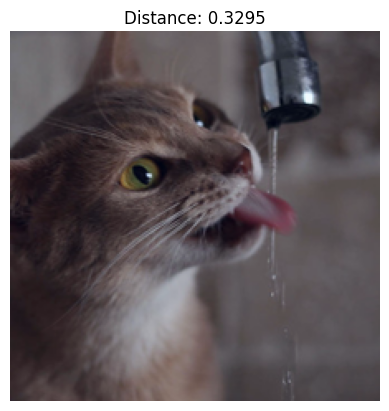

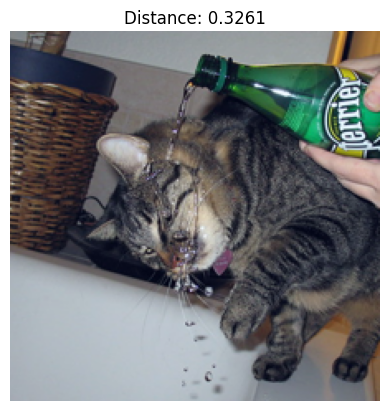

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Print keys of a sample dataset element for debugging
print("Keys in a sample dataset element:")
if len(ds['validation']) > 0:
    print(ds['validation'][0].keys())

for idx, distance in indices_distances:
    # Get the image from the dataset using the index
    if 'pixel_values' in ds['validation'][int(idx)]:
        # 'pixel_values' is a tensor, convert it to a PIL Image
        # Assuming the tensor is in (C, H, W) format
        image_tensor = ds['validation'][int(idx)]['pixel_values']
        # Remove batch dimension if present (it shouldn't be here, but good practice)
        if image_tensor.ndim == 4:
            image_tensor = image_tensor.squeeze(0)

        # Normalize the pixel values from the range [-1.72, 2.03] (approx) to [0, 255]
        # Find the min and max values of the tensor
        min_val = torch.min(image_tensor)
        max_val = torch.max(image_tensor)
        # Apply min-max normalization to scale to [0, 1]
        normalized_image_tensor = (image_tensor - min_val) / (max_val - min_val)
        # Scale to [0, 255] and convert to uint8
        image_np = (normalized_image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

        image = Image.fromarray(image_np)

        plt.imshow(image)
        plt.title(f"Distance: {distance:.4f}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image key 'pixel_values' not found for index {idx}")